In [2]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import warnings

In [98]:
import xarray as xr

models = ["GAM", "GBM"]
taxas = ["Mammals", "Bird","Amphibians"]
habitats = ["forest"]
scenarios = ["rcp26","rcp60"]
historical_time = 1146
future_times = [65]

for scenario in scenarios:
    for habitat in habitats:
        for future_time in future_times:
            for model in models:
                combined_hist_newvalue_datasets = []
                combined_hist_sum_datasets = []
                combined_future_newvalue_datasets = []
                combined_future_sum_datasets = []
                
                for taxa in taxas:
                    # Historical
                    newvalue_hist = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_summedprobs_newvalue_{habitat}.nc"
                    sumbin_hist = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_summedprobs_sum_{habitat}.nc"

                    mean_value_bin_hist = xr.open_dataset(newvalue_hist, decode_times=False).to_array()
                    mean_sum_bin_hist = xr.open_dataset(sumbin_hist, decode_times=False).to_array()
                    
                    combined_hist_newvalue_datasets.append(mean_value_bin_hist)
                    combined_hist_sum_datasets.append(mean_sum_bin_hist)

                    # Future
                    newvalue_fut = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_summedprobs_newvalue_{habitat}.nc"
                    sumbin_fut = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_summedprobs_sum_{habitat}.nc"

                    mean_value_bin_future = xr.open_dataset(newvalue_fut, decode_times=False).to_array()
                    mean_sum_bin_future = xr.open_dataset(sumbin_fut, decode_times=False).to_array()

                    combined_future_newvalue_datasets.append(mean_value_bin_future)
                    combined_future_sum_datasets.append(mean_sum_bin_future)

                # Concatenate over the taxa dimension
                combined_hist_newvalue = xr.concat(combined_hist_newvalue_datasets, dim='taxa')
                combined_hist_sum = xr.concat(combined_hist_sum_datasets, dim='taxa')
                combined_future_newvalue = xr.concat(combined_future_newvalue_datasets, dim='taxa')
                combined_future_sum = xr.concat(combined_future_sum_datasets, dim='taxa')

                combined_hist_newvalue = combined_hist_newvalue.sum(dim='taxa')
                combined_hist_sum = combined_hist_sum.sum(dim='taxa')
                combined_future_newvalue = combined_future_newvalue.sum(dim='taxa')
                combined_future_sum = combined_future_sum.sum(dim='taxa')

                # Saving concatenated results to new files
                combined_hist_newvalue.to_netcdf(f"/storage/scratch/users/ch21o450/data/intermediate_results/{model}_{historical_time}_{scenario}_summedprobs_newvalue_{habitat}.nc")
                combined_hist_sum.to_netcdf(f"/storage/scratch/users/ch21o450/data/intermediate_results/{model}_{historical_time}_{scenario}_summedprobs_sum_{habitat}.nc")
                combined_future_newvalue.to_netcdf(f"/storage/scratch/users/ch21o450/data/intermediate_results/{model}_{future_time}_{scenario}_summedprobs_newvalue_{habitat}.nc")
                combined_future_sum.to_netcdf(f"/storage/scratch/users/ch21o450/data/intermediate_results/{model}_{future_time}_{scenario}_summedprobs_sum_{habitat}.nc")


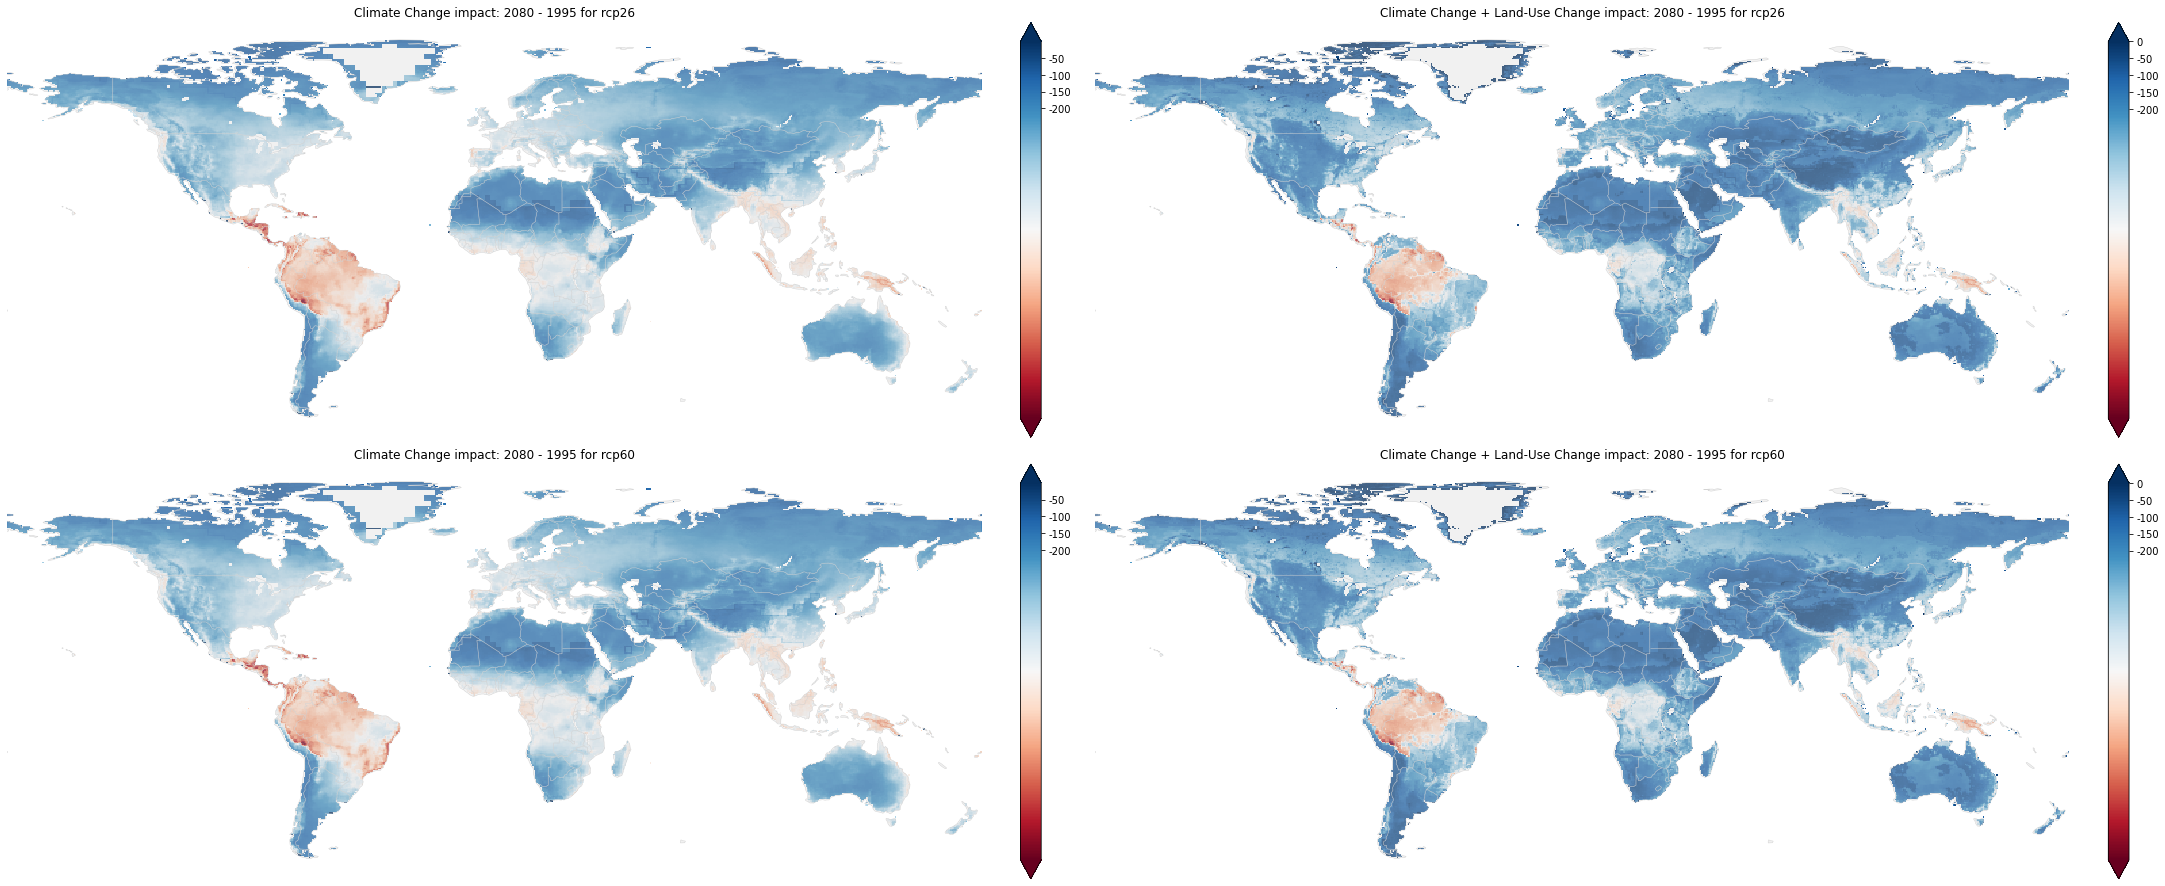

In [101]:
warnings.filterwarnings('ignore', category=UserWarning)

models =  ["GAM","GBM"]
habitats = ["forest"]
scenarios = ["rcp26","rcp60"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0

year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}
# Create empty arrays for storing the results for each taxa separately
diff_value_bin_combined_per_habitat = {}
diff_sum_bin_combined_per_habitat = {}
diff_combined_per_habitat = {}


for taxa in taxas:
    diff_value_bin_combined_per_habitat[habitat] = np.zeros([360, 720])
    diff_sum_bin_combined_per_habitat[habitat] = np.zeros([360, 720])
    diff_combined_per_habitat[habitat] = np.zeros([360, 720])

for habitat in habitats:
    for scenario in scenarios:
        historical_time = 1146
        future_times = [65]

        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        for future_time in future_times:
            diff_value_bin_models = []
            diff_sum_bin_models = []
            diff_models = []
            percent_changes = []


            for model in models:
                newvalue_hist = f"/storage/scratch/users/ch21o450/data/intermediate_results/{model}_{historical_time}_{scenario}_summedprobs_newvalue_{habitat}.nc"
                sumbin_hist = f"/storage/scratch/users/ch21o450/data/intermediate_results/{model}_{historical_time}_{scenario}_summedprobs_sum_{habitat}.nc"

                mean_value_bin_hist = xr.open_dataset(newvalue_hist, decode_times=False).to_array()
                mean_sum_bin_hist = xr.open_dataset(sumbin_hist, decode_times=False).to_array()
                mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
                mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)



                newvalue_fut = f"/storage/scratch/users/ch21o450/data/intermediate_results/{model}_{future_time}_{scenario}_summedprobs_newvalue_{habitat}.nc"
                sumbin_fut = f"/storage/scratch/users/ch21o450/data/intermediate_results/{model}_{future_time}_{scenario}_summedprobs_sum_{habitat}.nc"

                mean_value_bin_future = xr.open_dataset(newvalue_fut, decode_times=False).to_array()
                mean_value_bin_future = mean_value_bin_future.isel(variable=0)
               # mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)

                mean_sum_bin_future = xr.open_dataset(sumbin_fut, decode_times=False).to_array()
                mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

                # Calculate the differences
                diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
                diff = diff_sum_bin - diff_value_bin
                change_percent = ((diff_sum_bin - diff_value_bin) / (diff_value_bin)) * 100  # added small value to avoid division by zero
                percent_changes.append(change_percent)

                # append the differences to the model-specific lists
                diff_value_bin_models.append(diff_value_bin)
                diff_sum_bin_models.append(diff_sum_bin)
                diff_models.append(diff)

# Calculate the ensemble mean outside of the innermost loop
            diff_value_bin_ensemble = xr.concat(diff_value_bin_models, dim="ensemble").mean(dim="ensemble")
            diff_sum_bin_ensemble = xr.concat(diff_sum_bin_models, dim="ensemble").mean(dim="ensemble")

          #  diff_value_bin_ensemble = diff_value_bin_ensemble.isel(variable=0)
          #  diff_sum_bin_ensemble = diff_sum_bin_ensemble.isel(variable=0)
            diff_ensemble = diff_sum_bin_ensemble - diff_value_bin_ensemble

            # Append the ensemble mean to the overall results for this taxa
            diff_value_bin_combined_per_habitat[habitat] = diff_value_bin_ensemble
            diff_sum_bin_combined_per_habitat[habitat] = diff_sum_bin_ensemble
            diff_combined_per_habitat[habitat] = diff_ensemble

            # Calculate the overall species richness sum over all taxa
            diff_value_bin_combined = sum(diff_value_bin_combined_per_habitat.values())
            diff_sum_bin_combined = sum(diff_sum_bin_combined_per_habitat.values())
            diff_combined = sum(diff_combined_per_habitat.values())

            diff_newvalue= diff_value_bin_combined
            diff_sumbin = diff_sum_bin_combined
            diff = diff_combined
            
            land_sea_mask = xr.open_dataset("/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126.nc", decode_times=False).primf
            diff_newvalue_masked = diff_newvalue.where(land_sea_mask >=0)
            diff_newvalue =diff_newvalue_masked.isel(time=0)
            
            
            # Create subplots for each future time and scenario
            if plot_idx >= len(axes.flatten()):
                break
            ax1 = axes.flatten()[plot_idx]
            ax2 = axes.flatten()[plot_idx + 1]

            labels = ['a', 'b']
            # Define the colormap and the range of values for the colorbar

            vmin_b = diff_sum_bin.min().values
            vmax_b = diff_sum_bin.max().values

            cmap = plt.colormaps['RdBu']
            boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
            norm = BoundaryNorm(boundaries, cmap.N)

            # Plot the ensemble mean difference for each panel
            im1 = ax1.pcolormesh(diff_newvalue['lon'].values, diff_newvalue['lat'].values,np.where(diff_newvalue.values != 0, diff_newvalue.values, np.nan) , transform=ccrs.PlateCarree(), cmap=cmap)

            countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
            ax1.set_title(f"Climate Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

            ax1.axis('off')
            ax1.coastlines(color='lightgray', linewidth=0.5)
            ax1.set_extent((-180,180,-63,90))
            ax1.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

            ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
            tick_labels = [str(int(tick)) for tick in ticks_b]

            cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
            cbar1.set_ticklabels(tick_labels)

            im2 = ax2.pcolormesh(diff_sumbin['lon'].values, diff_sumbin['lat'].values,  np.where(diff_sumbin.values != 0, diff_sumbin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap)

            countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
            ax2.set_title(f"Climate Change + Land-Use Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

            ax2.axis('off')
            ax2.coastlines(color='lightgray', linewidth=0.5)
            ax2.set_extent((-180,180,-63,90))
            ax2.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)
            cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
            cbar2.set_ticklabels(tick_labels)

            # Increase the plot index by 2 to move to the next triplet of subplots
            plot_idx += 2

#plt.suptitle(future_time , size=16, y=0.8)
#plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Figure_2")

#plt.show() 
